In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    precision_score, recall_score, matthews_corrcoef, roc_curve,
    classification_report, confusion_matrix, RocCurveDisplay
)
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_predict, GridSearchCV
from sklearn.metrics import (
    roc_auc_score, precision_recall_curve, roc_curve,
    f1_score, recall_score, confusion_matrix
)

In [2]:
df = pd.read_csv('/Users/got2b/Desktop/НИИ СП им. Н.В. Склифосовского ДЗМ/Отделение лучевой диагностики/Гюльнара Кирамовна/ml_models/ml_model.csv')

In [3]:
df

,Несостоятельность_ЭИКМА,Пол,Стеноз_НСА,Диам_ПВА,Сахарный_диабет,Мультифокальный_атеросклероз,ЛСК_донора,ОК_донора,Возраст,Курение,Диаметр_ПВА x 10,Диам_донора х 10
0,0,1,0,2.3,0,2,39.0,43.0,56,1,23.0,11.0
1,0,1,0,2.5,0,2,28.0,36.0,58,1,25.0,13.0
2,0,2,50,2.4,0,1,28.0,25.0,78,2,24.0,9.0
3,0,1,0,2.2,1,1,32.0,41.0,66,1,22.0,13.0
4,0,1,45,2.4,0,2,39.0,46.0,48,2,24.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...
184,0,1,0,2.4,0,1,30.0,45.0,70,1,24.0,15.0
185,0,1,0,2.3,0,2,34.0,41.0,71,2,23.0,12.0
186,0,1,0,2.0,0,2,36.0,43.0,39,1,20.0,12.0
187,0,1,30,2.5,0,1,26.0,26.0,64,1,25.0,10.0


In [15]:
df = df.drop('Диам_ПВА', axis=1)

In [16]:
X = df.drop('Несостоятельность_ЭИКМА', axis=1)
y = df['Несостоятельность_ЭИКМА']

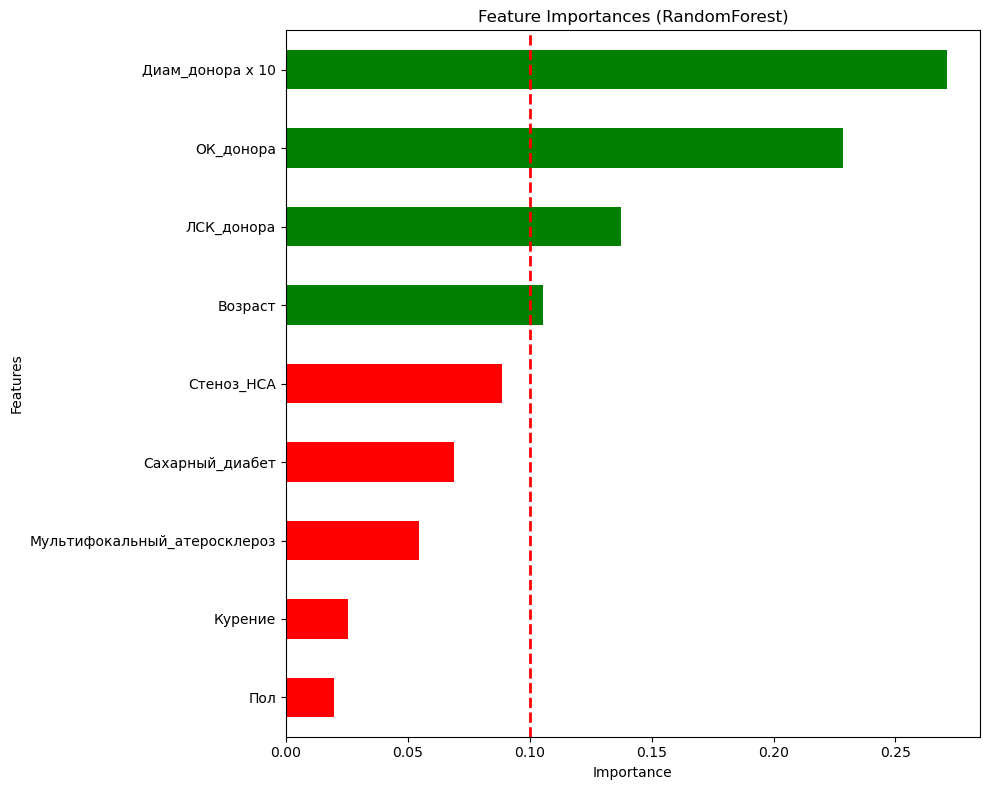

In [22]:
# 2) Отбор предикторов RandomForest и визуализация важности
rf_sel = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_sel.fit(X, y)
importances = pd.Series(rf_sel.feature_importances_, index=X.columns)
feat_threshold = 0.1
sorted_importances = importances.sort_values(ascending=True)
colors = sorted_importances.apply(lambda x: 'green' if x > feat_threshold else 'red')
plt.figure(figsize=(10, 8))
sorted_importances.plot(kind='barh', color=colors)
plt.axvline(x=feat_threshold, color='red', linestyle='--', linewidth=2)
plt.title('Feature Importances (RandomForest)')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

In [23]:
# Выбор признаков выше порога
selected_features = importances[importances > feat_threshold].index.tolist()
print(f"Selected features (importance > {feat_threshold}):", selected_features)
X_sel = X[selected_features]

Selected features (importance > 0.1): ['ЛСК_донора', 'ОК_донора', 'Возраст', 'Диам_донора х 10']


In [24]:
# 3) Пайплайны моделей
lr_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(random_state=42, class_weight='balanced', solver='liblinear'))
])
rf_pipe = Pipeline([
    ('clf', RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1))
])

In [25]:
# 4) CV и подбор гиперпараметров (по AUC)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
param_grid_lr = {'clf__C': [0.01, 0.1, 1, 10], 'clf__penalty': ['l1', 'l2']}
param_grid_rf = {'clf__n_estimators': [100, 200, 500], 'clf__max_depth': [None, 5, 10], 'clf__min_samples_split': [2, 5, 10]}

grid_lr = GridSearchCV(lr_pipe, param_grid_lr, cv=cv, scoring='roc_auc', n_jobs=-1)
grid_rf = GridSearchCV(rf_pipe, param_grid_rf, cv=cv, scoring='roc_auc', n_jobs=-1)
grid_lr.fit(X_sel, y)
grid_rf.fit(X_sel, y)
print("Best LR params (AUC):", grid_lr.best_params_)
print("Best RF params (AUC):", grid_rf.best_params_)

best_lr = grid_lr.best_estimator_
best_rf = grid_rf.best_estimator_

Best LR params (AUC): {'clf__C': 1, 'clf__penalty': 'l1'}
Best RF params (AUC): {'clf__max_depth': 10, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}


In [26]:
# 5) CV-предсказания вероятностей для класса 1
proba1_lr = cross_val_predict(best_lr, X_sel, y, cv=cv, method='predict_proba')[:, 1]
proba1_rf = cross_val_predict(best_rf, X_sel, y, cv=cv, method='predict_proba')[:, 1]

In [27]:
# 6) Поиск оптимального порога по Youden's J (максимум TPR-FPR)
fpr_lr, tpr_lr, thr_lr = roc_curve(y, proba1_lr)
youden_lr = tpr_lr - fpr_lr
best_idx_lr = np.argmax(youden_lr)
best_thr_lr = thr_lr[best_idx_lr]

fpr_rf, tpr_rf, thr_rf = roc_curve(y, proba1_rf)
youden_rf = tpr_rf - fpr_rf
best_idx_rf = np.argmax(youden_rf)
best_thr_rf = thr_rf[best_idx_rf]

print(f"Optimal threshold by Youden's J LR = {best_thr_lr:.2f}")
print(f"Optimal threshold by Youden's J RF = {best_thr_rf:.2f}")

Optimal threshold by Youden's J LR = 0.58
Optimal threshold by Youden's J RF = 0.05


In [28]:
# 7) Оценка метрик при найденных порогах для класса 1
results = {}
for name, proba, thr in [('LogisticRegression', proba1_lr, best_thr_lr), ('RandomForest', proba1_rf, best_thr_rf)]:
    y_pred = (proba >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    sensitivity = recall_score(y, y_pred)
    specificity = tn / (tn + fp)
    auc = roc_auc_score(y, proba)
    results[name] = {'Threshold': thr, 'AUC': auc, 'Sensitivity': sensitivity, 'Specificity': specificity, 'F1-score': f1_score(y, y_pred)}

print("\nMetrics for class 1 (непроходимость):")
for model, metrics in results.items():
    print(f"\n=== {model} ===")
    for metric, val in metrics.items():
        print(f"{metric}: {val:.3f}")


Metrics for class 1 (непроходимость):

=== LogisticRegression ===
Threshold: 0.584
AUC: 0.729
Sensitivity: 0.706
Specificity: 0.860
F1-score: 0.453

=== RandomForest ===
Threshold: 0.050
AUC: 0.815
Sensitivity: 0.824
Specificity: 0.709
F1-score: 0.346


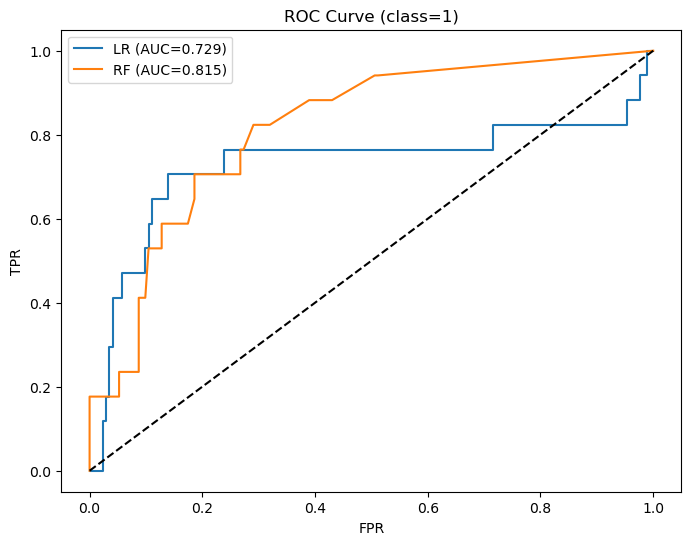

In [30]:
# 8) Визуализация ROC кривых для класса 1
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f"LR (AUC={roc_auc_score(y, proba1_lr):.3f})")
plt.plot(fpr_rf, tpr_rf, label=f"RF (AUC={roc_auc_score(y, proba1_rf):.3f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve (class=1)')
plt.legend()

In [31]:
import os, pickle

# 1) Создайте папки рядом с вашим notebook'ом, если их нет
os.makedirs('models', exist_ok=True)
os.makedirs('artifacts', exist_ok=True)

# 2) Сохраните модели
with open('models/best_rf.pkl', 'wb') as f:
    pickle.dump(best_rf, f)
with open('models/best_lr.pkl', 'wb') as f:
    pickle.dump(best_lr, f)

# 3) Сохраните список признаков
with open('artifacts/selected_features.pkl', 'wb') as f:
    pickle.dump(selected_features, f)

# 4) Сохраните пороги в словарь
thresholds = {'rf': best_thr_rf, 'lr': best_thr_lr}
with open('artifacts/thresholds.pkl', 'wb') as f:
    pickle.dump(thresholds, f)

print("Артефакты сохранены в папках models/ и artifacts/")

Артефакты сохранены в папках models/ и artifacts/
